In [1]:
%load_ext autoreload
%autoreload 2

## Load Library

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import torch
import numpy as np

/opt/anaconda3/envs/batinf/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import os
os.chdir('../')
from src.model import predict

In [4]:
# set plotting style
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.size'] = 14
plt.rcParams['figure.dpi'] = 200
fig_size = (8, 4)

## Load Experimental Data

In [5]:
data = pd.read_csv('./data/cleaned_data.csv')
data.drop(columns=['C2H4', 'CO', 'H2', 'EtoH', 'Formate'], inplace=True)
data.head()

,cDen,Pot,Sn %,pH
0,150,3.5,100,14.05
1,150,3.3,80,14.05
2,150,3.2,50,14.05
3,150,3.1,10,14.05
4,150,3.0,5,14.05


In [6]:
data.describe().transpose()['max']

cDen    450.00
Pot       5.10
Sn %    100.00
pH       14.05
Name: max, dtype: float64

In [7]:
# normalize the data with max values
from src.utils import get_weight
data['Sn %'] /= 100
data['weight'] = data['Sn %'].apply(get_weight)
data['Cu %'] = 1 - data['Sn %']

data.describe().transpose()['max']

cDen      450.00
Pot         5.10
Sn %        1.00
pH         14.05
weight    118.71
Cu %        1.00
Name: max, dtype: float64

In [8]:
# normalize the data with max values

data['weight'] /= 118.71
data['Pot'] /= 5.10
data['pH'] /= 14.05
data['cDen'] /= 450.00

In [9]:
output = pd.read_csv('./data/cleaned_data.csv')
output.drop(columns=['Pot', 'pH', 'cDen', 'Sn %'], inplace=True)
output.head()   

,C2H4,CO,H2,EtoH,Formate
0,0.0,23.0,12.0,0.0,61.0
1,0.0,23.0,7.0,0.0,66.0
2,0.0,34.0,5.0,3.0,52.0
3,1.0,42.0,5.0,2.0,42.0
4,4.0,48.0,5.0,10.0,19.0


In [10]:
data.head()

,cDen,Pot,Sn %,pH,weight,Cu %
0,0.333333,0.686275,1.00,1.0,1.000000,0.00
1,0.333333,0.647059,0.80,1.0,0.907061,0.20
2,0.333333,0.627451,0.50,1.0,0.767652,0.50
3,0.333333,0.607843,0.10,1.0,0.581774,0.90
4,0.333333,0.588235,0.05,1.0,0.558539,0.95


In [11]:
# rerrange the columns
features = ['cDen', 'Pot', 'Sn %', 'pH', 'weight', 'Cu %'] # from the model definition
data = data[features]
data.head()

,cDen,Pot,Sn %,pH,weight,Cu %
0,0.333333,0.686275,1.00,1.0,1.000000,0.00
1,0.333333,0.647059,0.80,1.0,0.907061,0.20
2,0.333333,0.627451,0.50,1.0,0.767652,0.50
3,0.333333,0.607843,0.10,1.0,0.581774,0.90
4,0.333333,0.588235,0.05,1.0,0.558539,0.95


In [12]:
# set feature names
data.columns = [
                r'$\rm Current \ density$', 
                r'$\rm Potential$', 
                r'$\rm Sn$', 
                r'$\rm pH$', 
                r'$\rm Weight$', 
                r'$\rm Cu$']

## Perform Shap Analysis

In [13]:
model_path = './neuralnetwork/results'

### 1. HCOOH

In [14]:
def f_instance(df, index=0):
    input_df = np.asarray(df)
    input = torch.from_numpy(input_df).float()
    out_semi = predict(data=input, dir=model_path) 
    out = [out_semi[i][:, index].detach().numpy() for i in range(len(out_semi))]

    return np.mean(out, axis=0)

explainer = shap.Explainer(f_instance, data)
shap_values = explainer(data)

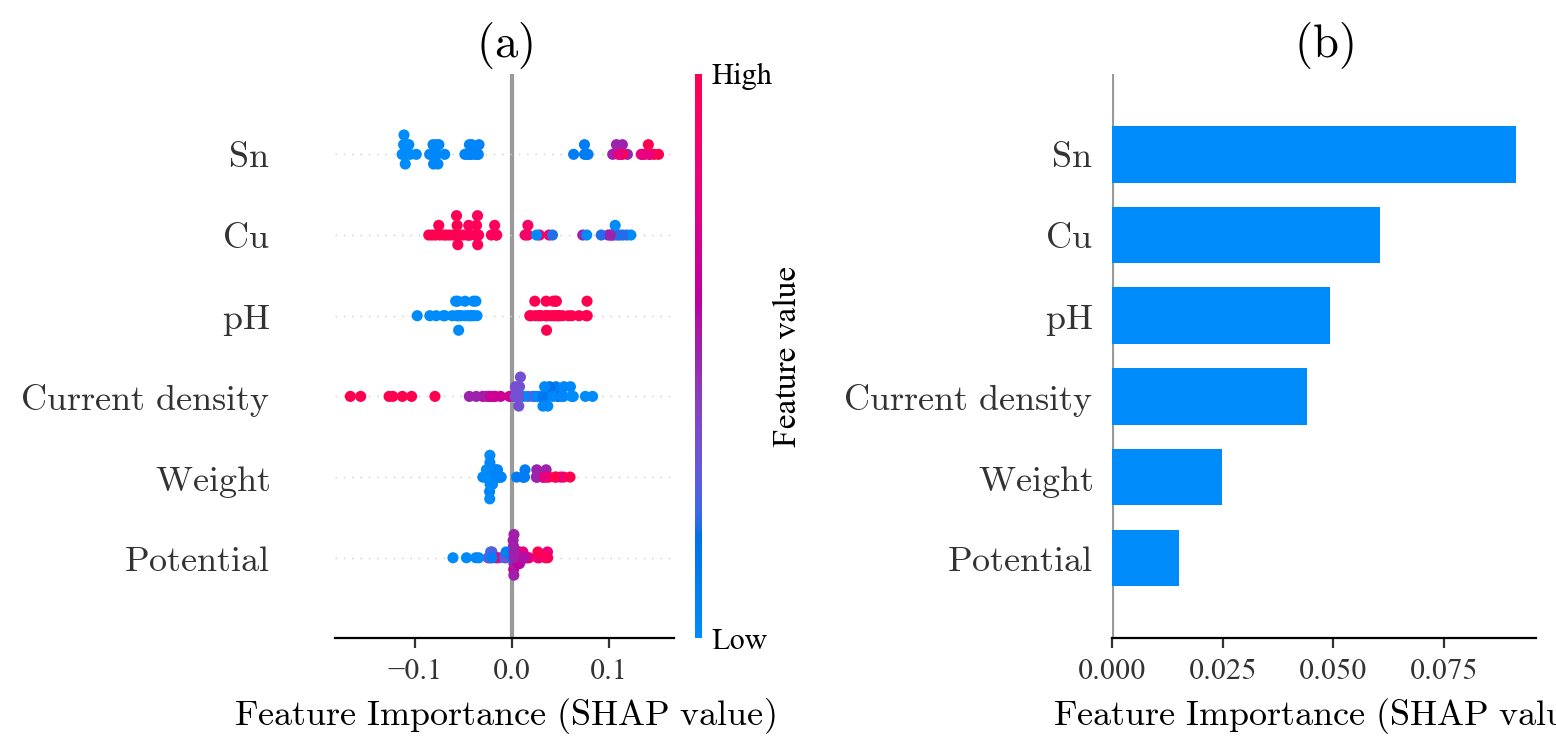

In [15]:
fig1x = plt.figure()

ax1x0 = fig1x.add_subplot(121)
shap.summary_plot(shap_values, features=data, show=False,)
ax1x0.set_xlabel(r'$\rm Feature\ Importance \ (SHAP \ value)$')
ax1x0.set_title(r'$\rm (a)$')

ax1x1 = fig1x.add_subplot(122)
shap.summary_plot(shap_values, features=data, show=False, plot_type='bar')
ax1x1.set_xlabel(r'$\rm Feature\ Importance \ (SHAP \ value)$')
ax1x1.set_title(r'$\rm (b)$')

plt.gcf().set_size_inches(fig_size)
plt.tight_layout()
plt.show()

In [16]:
idx_max, idx_min = np.argmax(output['Formate']), np.argmin(output['Formate'])
print(f"Min: {output['Formate'].iloc[idx_min]:.2f}%, Max: {output['Formate'].iloc[idx_max]:.2f}%")

Min: 1.77%, Max: 70.00%


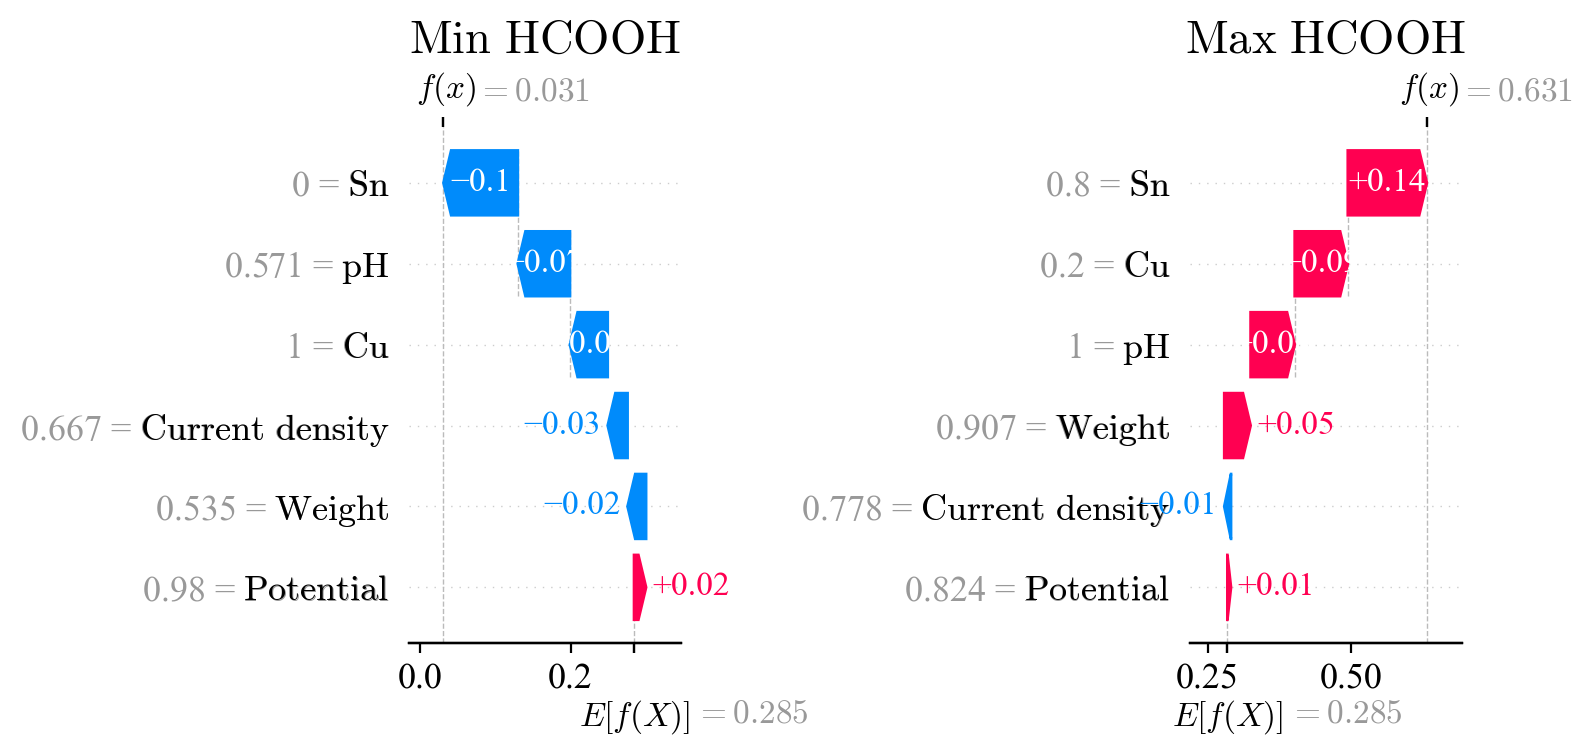

In [17]:
fig = plt.figure()

ax0 = fig.add_subplot(121)
shap.plots.waterfall(shap_values[idx_min], show=False)
ax0.set_title(r'$\rm Min \ HCOOH$')

ax1 = fig.add_subplot(122)
shap.plots.waterfall(shap_values[idx_max], show=False)
ax1.set_title(r'$\rm Max \ HCOOH$')

plt.gcf().set_size_inches(fig_size)
plt.tight_layout()
plt.show()

### 2. C2H5OH

In [18]:
def f_instance_2(df, index=1):
    input_df = np.asarray(df)
    input = torch.from_numpy(input_df).float()
    out_semi = predict(data=input, dir=model_path) 
    out = [out_semi[i][:, index].detach().numpy() for i in range(len(out_semi))]

    return np.mean(out, axis=0)

explainer_2 = shap.Explainer(f_instance_2, data)
shap_values_2 = explainer_2(data)

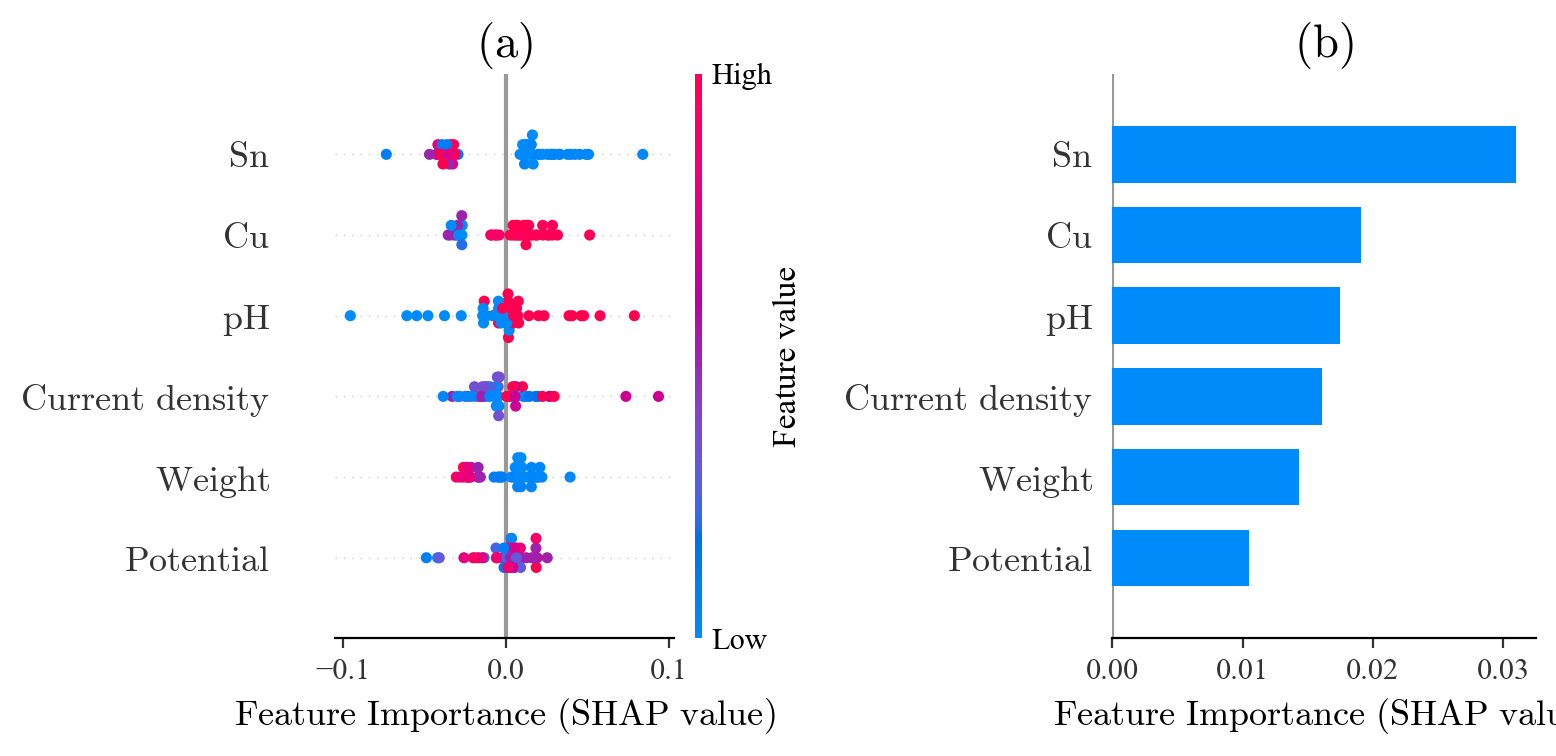

In [19]:
fig2x = plt.figure()

ax2x0 = fig2x.add_subplot(121)
shap.summary_plot(shap_values_2, features=data, show=False,)
ax2x0.set_xlabel(r'$\rm Feature\ Importance \ (SHAP \ value)$')
ax2x0.set_title(r'$\rm (a)$')


ax2x1 = fig2x.add_subplot(122)
shap.summary_plot(shap_values_2, features=data, show=False, plot_type='bar')
ax2x1.set_xlabel(r'$\rm Feature\ Importance \ (SHAP \ value)$')
ax2x1.set_title(r'$\rm (b)$')

plt.gcf().set_size_inches(fig_size)
plt.tight_layout()
plt.show()

In [20]:
idx_max, idx_min = np.argmax(output['EtoH']), np.argmin(output['EtoH'])
print(f"Min: {output['EtoH'].iloc[idx_min]:.2f}%, Max: {output['EtoH'].iloc[idx_max]:.2f}%")

Min: 0.00%, Max: 48.00%


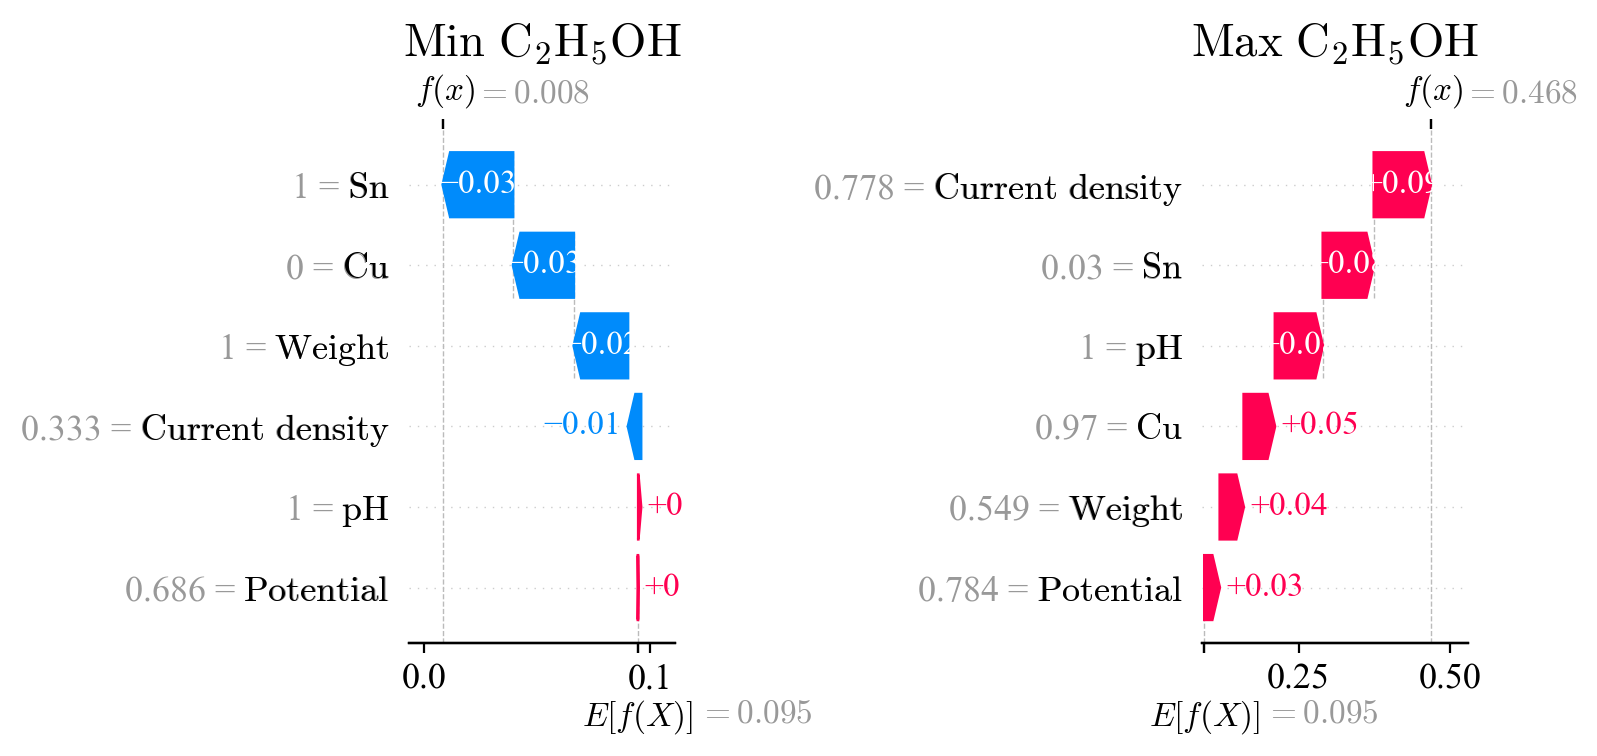

In [21]:
fig2 = plt.figure()

ax20 = fig2.add_subplot(121)
shap.plots.waterfall(shap_values_2[idx_min], show=False)
ax20.set_title(r'$\rm Min \ C_2H_5OH$')

ax21 = fig2.add_subplot(122)
shap.plots.waterfall(shap_values_2[idx_max], show=False)
ax21.set_title(r'$\rm Max \ C_2H_5OH$')

plt.gcf().set_size_inches(fig_size)
plt.tight_layout()
plt.show()

### 3. H2

In [22]:
def f_instance_3(df, index=2):
    input_df = np.asarray(df)
    input = torch.from_numpy(input_df).float()
    out_semi = predict(data=input, dir=model_path) 
    out = [out_semi[i][:, index].detach().numpy() for i in range(len(out_semi))]

    return np.mean(out, axis=0)

explainer_3 = shap.Explainer(f_instance_3, data)
shap_values_3 = explainer_3(data)

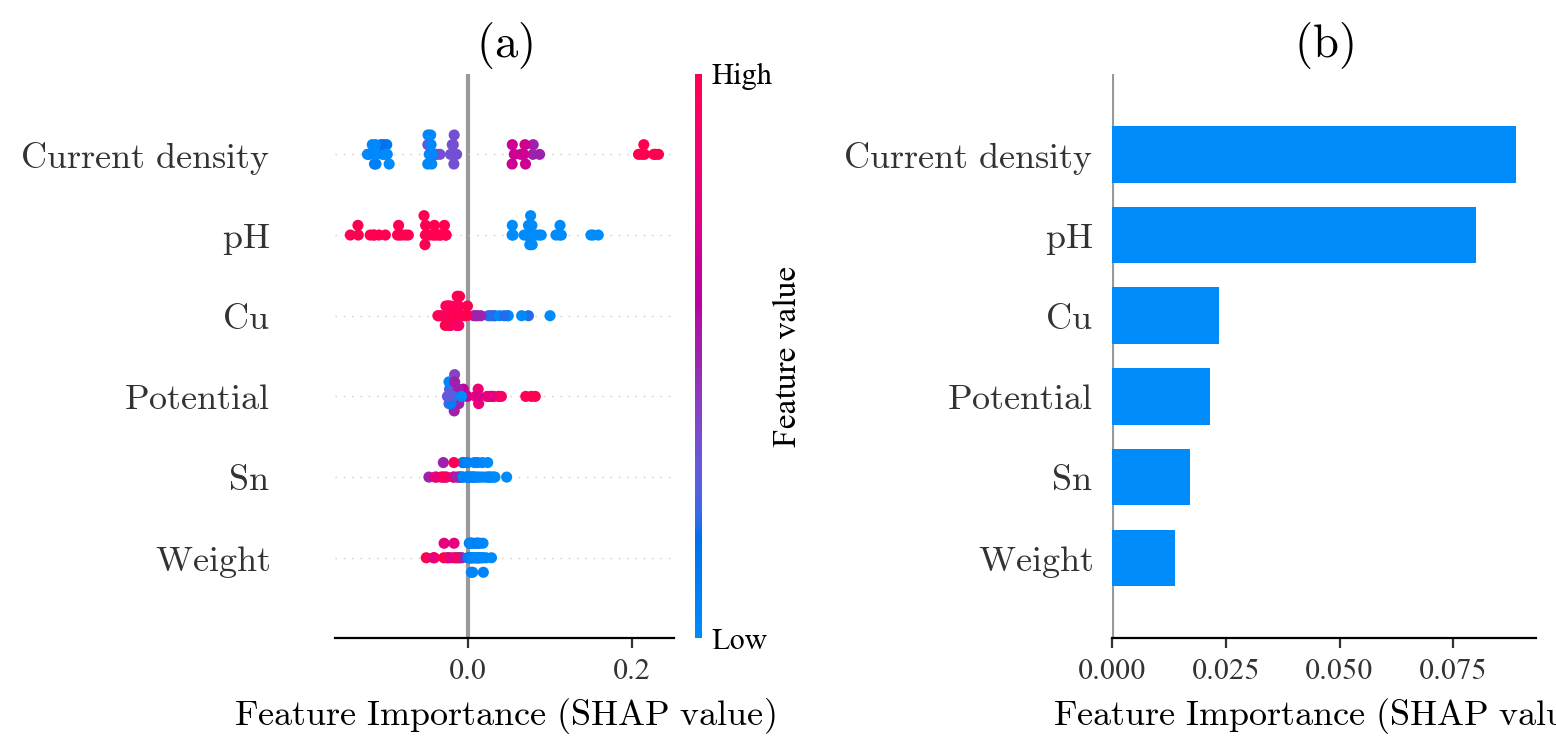

In [23]:
fig3x = plt.figure()

ax3x0 = fig3x.add_subplot(121)
shap.summary_plot(shap_values_3, features=data, show=False,)
ax3x0.set_xlabel(r'$\rm Feature\ Importance \ (SHAP \ value)$')
ax3x0.set_title(r'$\rm (a)$')

ax3x1 = fig3x.add_subplot(122)
shap.summary_plot(shap_values_3, features=data, show=False, plot_type='bar')
ax3x1.set_xlabel(r'$\rm Feature\ Importance \ (SHAP \ value)$')
ax3x1.set_title(r'$\rm (b)$')

plt.gcf().set_size_inches(fig_size)
plt.tight_layout()
plt.show()

In [24]:
idx_max, idx_min = np.argmax(output['H2']), np.argmin(output['H2'])
print(f"Min: {output['H2'].iloc[idx_min]:.2f}%, Max: {output['H2'].iloc[idx_max]:.2f}%")

Min: 5.00%, Max: 54.18%


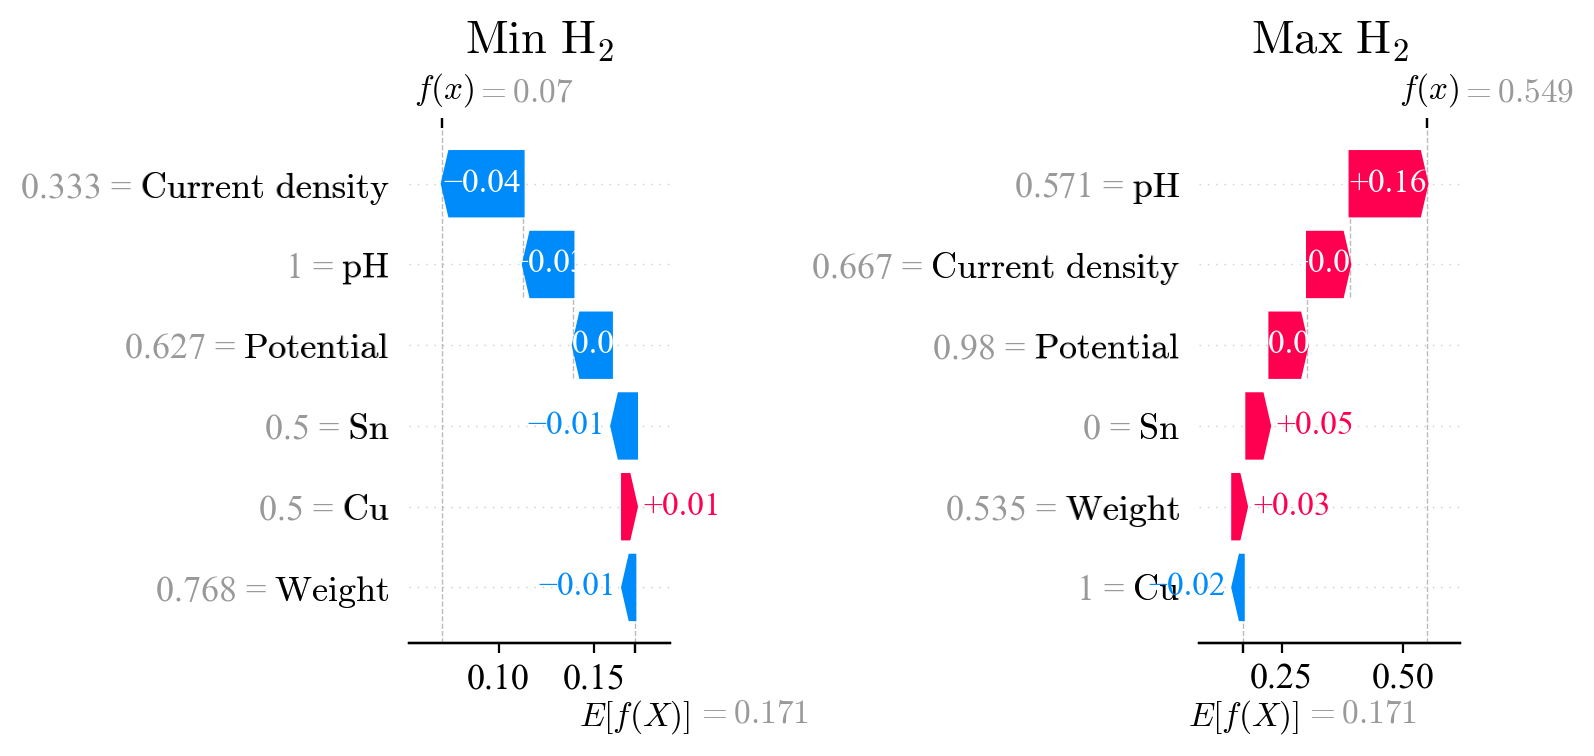

In [25]:
fig3 = plt.figure()

ax30 = fig3.add_subplot(121)
shap.plots.waterfall(shap_values_3[idx_min], show=False)
ax30.set_title(r'$\rm Min \ H_2$')

ax31 = fig3.add_subplot(122)
shap.plots.waterfall(shap_values_3[idx_max], show=False)
ax31.set_title(r'$\rm Max \ H_2$')

plt.gcf().set_size_inches(fig_size)
plt.tight_layout()
plt.show()